In [15]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import numpy as np
import pandas as pd
import cv2

In [16]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D, MaxPool3D, Embedding, GRU
from keras.layers.convolutional import Convolution2D, UpSampling2D, SeparableConv2D, UpSampling3D
from keras.layers import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import keras.backend as K
from keras import layers
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize, word_tokenize 
import tensorflow as tf

In [3]:
img_paths = glob.glob('cleaned-data\*.jpg')

In [4]:
captions = pd.read_csv('./coco-captions-2017-clean.csv')

In [231]:
captions.values[130]

array([130, 661, 'A chicken sandwich in a wrapper near a cell phone.'],
      dtype=object)

In [22]:
annot_list = captions.values[:128]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
    temp = [] 
      
    #tokenize the captions into words 
    for j in word_tokenize(row[2]): 
        temp.append(j.lower()) 
        corpus_dict[j.lower()] = 0
    if len(temp) > max_sequence_length:
        max_sequence_length = len(temp)
    data.append(temp) 

for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())

In [21]:
corpus_dict.keys()

dict_keys(['closeup', 'of', 'bins', 'food', 'that', 'include', 'broccoli', 'and', 'bread', '.', 'a', 'giraffe', 'eating', 'from', 'the', 'top', 'tree', 'flower', 'vase', 'is', 'sitting', 'on', 'porch', 'stand', 'zebra', 'grazing', 'lush', 'green', 'grass', 'in', 'field', 'woman', 'swim', 'suit', 'holding', 'parasol', 'sunny', 'day', 'this', 'wire', 'metal', 'rack', 'holds', 'several', 'pairs', 'shoes', 'sandals', 'couple', 'men', 'riding', 'horses', 'they', 'are', 'brave', 'for', 'jungle', 'those', 'elephants', 'black', 'silver', 'clock', 'tower', 'at', 'an', 'intersection', 'near', 'train', 'coming', 'to', 'stop', 'tracks', 'out', 'side', 'snuggling', 'each', 'other', 'forest', 'motorcycle', 'parked', 'parking', 'space', 'next', 'another', 'picture', 'dog', 'laying', 'ground', 'young', 'man', 'skateboard', 'into', 'air', 'lighted', 'owl', 'candle', 'sits', 'big', 'airplane', 'flying', 'blue', 'sky', 'motor', 'bike', 'across', 'oven', 'with', 'stove', 'it', 'kitchen', 'white', 'plate',

In [25]:
w2v_model = Word2Vec.load('./text_encoding.bin')

In [63]:
captions_X = []
caption_strings = []

for row in annot_list:
    caption_conv = []
    for word in word_tokenize(row[2].lower()):
        caption_conv.append(w2v_model[word])
    captions_X.append(np.array(caption_conv))
    caption_strings.append(row[2].lower())
    
    
    

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [64]:
len(w2v_model.wv.vocab)

13896

In [65]:
# Pad with 0-vectors
for i in range(len(captions_X)):
    captions_X[i].resize((27, 100))


In [83]:
captions_X = np.array(captions_X)

In [229]:
len(captions_X)

128

In [12]:
# annot_df = pd.read_csv('./coco-captions-2017-clean.csv')
# annot_list = annot_df.values[:1167]
# data = [] 
# corpus_dict = {}
# # iterate through each caption 
# max_sequence_length = float("-inf")
# for row in annot_list: 
#     temp = [] 
      
#     #tokenize the captions into words 
#     for j in word_tokenize(row[2]): 
#         temp.append(j.lower()) 
#         corpus_dict[j.lower()] = 0
#     if len(temp) > max_sequence_length:
#         max_sequence_length = len(temp)
#     data.append(temp) 
  
# for index, word in enumerate(corpus_dict.keys()):
#     corpus_dict[word] = index + 1
    
# corpus_size = len(corpus_dict.keys())
# print("corpus size: {}".format(corpus_size))
# print("max sequence length: {}".format(max_sequence_length))

In [84]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [85]:
imgs_all = data_loader('./cleaned-data/')
imgs_y = imgs_all[:128]

In [86]:
autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5')

In [87]:
decoder = autoencoder.layers[2]

In [88]:
for layer in decoder.layers:
    layer.trainable = False
decoder.trainable = False

In [153]:
def build_intermediate_model(input_shape, name='textencoder', encode_channels=[4, 8, 16, 32]):
    embedding_size = 64
    gru_size = 1024
    input_length = 27
    input_layer = Input(shape=input_shape)
#     encoder_block = Embedding(434, 64, input_length=27)(input_layer)
    
    
    embedded_seq, state_i = GRU(gru_size, return_state=True)(input_layer)
    state_i = Dense(1024)(state_i)
    state_i = LeakyReLU()(state_i)

    
        
 
    encoder_block = Reshape((32, 32, 1))(state_i)
    
    for index, channel in enumerate(encode_channels):
        
        shortcut = Conv2D(channel, 3, padding='same', trainable=False)(encoder_block)
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)    
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        
        
        encoder_block = Add()([encoder_block, shortcut])
        
        #encoder_block = MaxPool2D()(encoder_block) # losses information density
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
#     encoder_block = Reshape((8, 8, 1))(state_i)
#     encoder_block = Conv2DTranspose(1, 3, strides=2, padding='same')(encoder_block)
#     encoder_block = LeakyReLU()(encoder_block)
#     encoder_block = Conv2DTranspose(1, 3, strides=2, padding='same')(encoder_block)
#     encoder_block = LeakyReLU()(encoder_block)
    
#     for index, channel in enumerate(encode_channels):
#     encoder_block = Conv2D(32, 3, strides=1, padding='same')(encoder_block)
#     encoder_block = LeakyReLU()(encoder_block)

    
    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [154]:
model_intermediate = build_intermediate_model((27, 100))

In [155]:
model_intermediate.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 27, 100)      0                                            
__________________________________________________________________________________________________
gru_11 (GRU)                    [(None, 1024), (None 3456000     input_16[0][0]                   
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1024)         1049600     gru_11[0][1]                     
__________________________________________________________________________________________________
leaky_re_lu_50 (LeakyReLU)      (None, 1024)         0           dense_9[0][0]                    
__________________________________________________________________________________________________
reshape_11

In [156]:
len(model_intermediate.layers)

45

In [157]:
def build_combined_model():
    input_caption = Input(shape=(27, 100))
    latent_representation = model_intermediate(input_caption)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_caption, decoded_img, name="text2img")
    return autoencoder

In [158]:
model_text2img = build_combined_model()

In [159]:
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        4542844   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 4,594,607
Trainable params: 4,536,522
Non-trainable params: 58,085
_________________________________________________________________


In [160]:
model_text2img.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])

Epoch 1/1000
128/128 [==============================] - 7s 57ms/step - loss: 0.1106 - acc: 0.4010
Epoch 2/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0935 - acc: 0.3975
Epoch 3/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0893 - acc: 0.3905
Epoch 4/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0864 - acc: 0.3955
Epoch 5/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0844 - acc: 0.3870
Epoch 6/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0822 - acc: 0.3876
Epoch 7/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0812 - acc: 0.3912
Epoch 8/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0796 - acc: 0.4053
Epoch 9/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0786 - acc: 0.4101
Epoch 10/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0762 - acc: 0.4440
Epoch 11/1000
128/128 [=====

128/128 [==============================] - 0s 3ms/step - loss: 0.0191 - acc: 0.5685
Epoch 85/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0192 - acc: 0.5903
Epoch 86/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0183 - acc: 0.5860
Epoch 87/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0193 - acc: 0.5855
Epoch 88/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0191 - acc: 0.5748
Epoch 89/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0190 - acc: 0.5672
Epoch 90/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0185 - acc: 0.5917
Epoch 91/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0197 - acc: 0.5889
Epoch 92/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0177 - acc: 0.5864
Epoch 93/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0192 - acc: 0.5686
Epoch 94/1000
128/128 [===========

128/128 [==============================] - 0s 3ms/step - loss: 0.0143 - acc: 0.6817
Epoch 168/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0142 - acc: 0.6855
Epoch 169/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0144 - acc: 0.6891
Epoch 170/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0141 - acc: 0.6817
Epoch 171/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0143 - acc: 0.6803
Epoch 172/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0145 - acc: 0.6731
Epoch 173/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0137 - acc: 0.6772
Epoch 174/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0138 - acc: 0.6949
Epoch 175/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0153 - acc: 0.6812
Epoch 176/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0149 - acc: 0.6855
Epoch 177/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0133 - acc: 0.6954
Epoch 250/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0127 - acc: 0.7060
Epoch 251/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0126 - acc: 0.6872
Epoch 252/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0133 - acc: 0.6939
Epoch 253/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0139 - acc: 0.7053
Epoch 254/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0125 - acc: 0.7159
Epoch 255/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0135 - acc: 0.7129
Epoch 256/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0127 - acc: 0.7128
Epoch 257/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0125 - acc: 0.7011
Epoch 258/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0121 - acc: 0.7018
Epoch 259/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0122 - acc: 0.7072
Epoch 332/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0116 - acc: 0.7046
Epoch 333/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0129 - acc: 0.6994
Epoch 334/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0129 - acc: 0.7156
Epoch 335/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0118 - acc: 0.7165
Epoch 336/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0120 - acc: 0.7192
Epoch 337/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0115 - acc: 0.7298
Epoch 338/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0133 - acc: 0.6927
Epoch 339/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0127 - acc: 0.7105
Epoch 340/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0130 - acc: 0.7055
Epoch 341/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0110 - acc: 0.7241
Epoch 414/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0111 - acc: 0.7256
Epoch 415/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0112 - acc: 0.7174
Epoch 416/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0114 - acc: 0.7168
Epoch 417/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0115 - acc: 0.6944
Epoch 418/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0115 - acc: 0.7195
Epoch 419/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0116 - acc: 0.7086
Epoch 420/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0114 - acc: 0.7265
Epoch 421/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0117 - acc: 0.7067
Epoch 422/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0116 - acc: 0.7212
Epoch 423/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0110 - acc: 0.7281
Epoch 496/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0107 - acc: 0.7300
Epoch 497/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0109 - acc: 0.7161
Epoch 498/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0111 - acc: 0.7052
Epoch 499/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0109 - acc: 0.7249
Epoch 500/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0117 - acc: 0.7160
Epoch 501/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0119 - acc: 0.7165
Epoch 502/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0110 - acc: 0.7299
Epoch 503/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0112 - acc: 0.7289
Epoch 504/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0116 - acc: 0.7074
Epoch 505/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0108 - acc: 0.7260
Epoch 578/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0108 - acc: 0.7277
Epoch 579/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0107 - acc: 0.7333
Epoch 580/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 0.7237
Epoch 581/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0106 - acc: 0.7293
Epoch 582/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0102 - acc: 0.7281
Epoch 583/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 0.7267
Epoch 584/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0106 - acc: 0.7230
Epoch 585/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0109 - acc: 0.7243
Epoch 586/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0112 - acc: 0.7200
Epoch 587/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0112 - acc: 0.7267
Epoch 660/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0106 - acc: 0.7225
Epoch 661/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0107 - acc: 0.7194
Epoch 662/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0104 - acc: 0.7314
Epoch 663/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0100 - acc: 0.7449
Epoch 664/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0108 - acc: 0.7240
Epoch 665/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0108 - acc: 0.7345
Epoch 666/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0100 - acc: 0.7402
Epoch 667/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0102 - acc: 0.7311
Epoch 668/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 0.7168
Epoch 669/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0112 - acc: 0.7256
Epoch 742/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0107 - acc: 0.7229
Epoch 743/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 0.7228
Epoch 744/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0105 - acc: 0.7255
Epoch 745/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0105 - acc: 0.7263
Epoch 746/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 0.7326
Epoch 747/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0097 - acc: 0.7347
Epoch 748/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.7421
Epoch 749/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.7430
Epoch 750/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.7383
Epoch 751/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 0.7257
Epoch 824/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 0.7301
Epoch 825/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0098 - acc: 0.7395
Epoch 826/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.7392
Epoch 827/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0098 - acc: 0.7454
Epoch 828/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 0.7259
Epoch 829/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0097 - acc: 0.7369
Epoch 830/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0097 - acc: 0.7282
Epoch 831/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0099 - acc: 0.7248
Epoch 832/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0108 - acc: 0.7389
Epoch 833/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0099 - acc: 0.7337
Epoch 906/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0106 - acc: 0.7342
Epoch 907/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0099 - acc: 0.7331
Epoch 908/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.7421
Epoch 909/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0100 - acc: 0.7420
Epoch 910/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 0.7294
Epoch 911/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0097 - acc: 0.7307
Epoch 912/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0095 - acc: 0.7353
Epoch 913/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0097 - acc: 0.7386
Epoch 914/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 0.7152
Epoch 915/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.7215
Epoch 988/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0094 - acc: 0.7354
Epoch 989/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0095 - acc: 0.7354
Epoch 990/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0094 - acc: 0.7365
Epoch 991/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0093 - acc: 0.7469
Epoch 992/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 0.7353
Epoch 993/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0104 - acc: 0.7281
Epoch 994/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0104 - acc: 0.7192
Epoch 995/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0095 - acc: 0.7339
Epoch 996/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.7400
Epoch 997/1000
128/128 [=

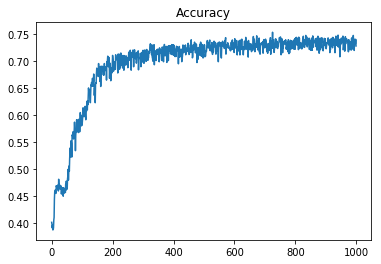

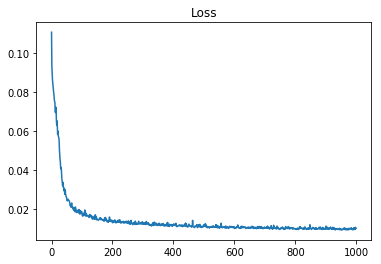

In [161]:
history = model_text2img.fit(captions_X, imgs_y, epochs=1000, batch_size=32, shuffle=True)
plot_history(history)

In [ ]:
for i in range (10, 50):
    history = model_text2img.fit(captions_X, imgs_y, epochs=1000, batch_size=32, shuffle=True)
    print(str(i) + 'k epochs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    model_text2img.save('.\\text2img-models\\text2img-' + str(i) + 'k-epochs.h5')
    plot_history(history)
#     show_converted(4)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [14]:
# model_text2img = load_model('./text2img-models/text2img-49k-epochs.h5')
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 27)                0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        520710    
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 572,473
Trainable params: 520,710
Non-trainable params: 51,763
_________________________________________________________________


C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


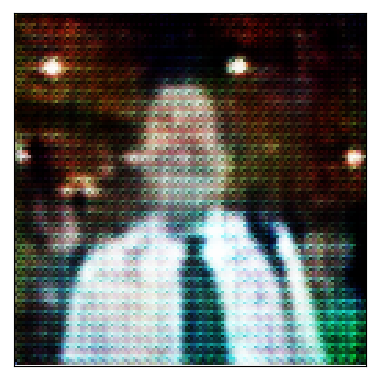

In [233]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
def rgb_imshow(img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor((img).astype(np.float32), cv2.COLOR_BGR2RGB))
#     plt.show()
def show_converted(img_index, step_count=None, caption=None):
    # print(caption_strings[img_index])
    figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
    if caption is None:
        img_input = imgs_y[img_index] #subset_X[img_index]
        plt.subplot(1,2,2)
        plt.title("Target image")
        rgb_imshow(img_input)
    
    plt.subplot(1,2,1)
    
    if caption is None:
        plt.title("Image generated from:\n\"" + caption_strings[img_index] +"\"")
        decoded_img = model_text2img.predict(np.array([captions_X[img_index]]), steps=step_count)[0]
    else:
        
        decoded_img = model_text2img.predict(np.array([caption]), steps=step_count)[0]
    
#     figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
    rgb_imshow(decoded_img)
#     plt.savefig('./gru-testing/gru-1024-dense-1024-residual/img-' + str(img_index),bbox_inches='tight')


# show_converted(2)
# show_converted(4)
# show_converted(18)
# show_converted(65)
# for i in range(65, 70):
show_converted(3, caption=caption_encoding('a man with a bushy beard and green tie.'))

# decoded_img1 = model_text2img.predict(np.array([captions_X[4]]))[0]
# decoded_img2 = model_text2img.predict(np.array([captions_X[5]]))[0]

# flat_img = np.array(decoded_img2 - decoded_img1)
# flat_img = flat_img.flatten()
# nonzero_elems = [x for x in flat_img if x != 0]
# print (len(decoded_img1.flatten()))
# print (len(nonzero_elems))
# print (np.max(flat_img))


In [176]:
def caption_encoding(string):
    caption_conv = []
    for word in word_tokenize(string.lower()):
        caption_conv.append(w2v_model[word])
    caption_conv = np.array(caption_conv)
    caption_conv.resize((27, 100))
    return caption_conv

In [97]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title("Loss")
    plt.show()

In [ ]:
np.shape(model_text2img.predict(np.array([captions_X[0]]))[0])

In [214]:
for cap in caption_strings:
    if 'man' in cap:
        print (cap)

woman in swim suit holding parasol on sunny day.
a young man riding a skateboard into the air.
a man riding a motor bike across a forest.
woman cutting pizza with fork and knife sitting next to young girl
a man and woman cut into a big cake 
a female in military uniform cutting a businessman's neck tie
a man standing holding a game controller and two people sitting
a man standing in front of a microwave next to pots and pans.
a man tossing an orange frisbee on top of a lush green field.
a man holding a glass of wine on it's side.
a man with a bushy beard and green tie.
a man talking on his phone in the public.
a cat is lying on its back in a man's lap.
a standing woman with a remote control in hand 
a man holding a camera up over his left shoulder.
a man getting ready to bunt the baseball
a man holding his hands together while sitting on a bench.
man on dirt bike with a redheaded woman in his lap.
a man standing next to a large red bus.
people gather around as a man gets into an old-ti

In [211]:
w2v_model.most_similar('pizza')

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sandwich', 0.7644851803779602),
 ('cake', 0.7399096488952637),
 ('bread', 0.7351022362709045),
 ('food', 0.7136834859848022),
 ('doughnut', 0.7128810882568359),
 ('pizzas', 0.7076917886734009),
 ('dessert', 0.7038589119911194),
 ('pie', 0.6961496472358704),
 ('meal', 0.6948972940444946),
 ('knife', 0.6794041991233826)]

In [ ]:
from keras.utils import plot_model

plot_model(model_intermediate,  show_shapes=True, to_file='./vis/text2img-vis.jpg')